# 5. Defending against the Fast Gradient Sign Attack, using the Arms Race Defense

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.2 (06/07/2023)

**Requirements:**
- Python 3 (tested on v3.11.4)
- Matplotlib (tested on v3.7.1)
- Numpy (tested on v1.24.3)
- Pillow (tested on v9.3.0)
- Torch (tested on v2.0.1+cu118)
- Torchvision (tested on v0.15.2+cu118)

### Imports

In [1]:
# Future
from __future__ import print_function
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Torchvision
from torchvision import datasets, transforms

In [2]:
# NOTE: This is a fix to work around the "User-agent" issue 
# when downloading the MNIST dataset
from six.moves import urllib
opener_req = urllib.request.build_opener()
opener_req.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener_req)

### CUDA Setup

In [3]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


### Dataset and Dataloader

In [4]:
# Transform definition
# (Basic: only convert image to torch tensor)
tf = transforms.Compose([transforms.ToTensor()])
# MNIST dataset and dataloader
# (For testing only, we will use a pre-trained model)
ds = datasets.MNIST('./data', train = False, download = True, transform = tf)
test_loader = torch.utils.data.DataLoader(ds, batch_size = 1, shuffle = True)

### Loading a pre-trained model

As in previous notebooks.

In [5]:
# Model definition
class Net(nn.Module):
    """
    This is a basic Neural Net for MNIST
    - Two convolutions, into ReLU activations and dropouts after ReLU,
    - Flattening,
    - Fully connected, into ReLU activation and dropout after ReLU,
    - Fully connected, into Log-Softmax.
    """
    
    def __init__(self):
        super(Net, self).__init__()
        # Conv. 1
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
        # Conv. 2
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        # Dropout for Conv. layers
        self.conv2_drop = nn.Dropout2d()
        # FC 1
        self.fc1 = nn.Linear(320, 50)
        # FC 2
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # Conv. 1 + ReLU + Dropout
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Conv. 2 + ReLU + Dropout
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten
        x = x.view(-1, 320)
        # FC 1 + ReLU + Droupout 
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        # FC 2 + Log-Softmax
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

In [6]:
# Load the pretrained model
model = Net()
pretrained_model = "./mnist_model.data"
model.load_state_dict(torch.load(pretrained_model, map_location = 'cpu'))
model.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [7]:
# Set the model in evaluation mode
# (Important, because we have dropout layers!)
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### Fast Gradient Sign Method (FGSM) attack function

As in notebook 3.

In [8]:
def fgsm_attack(image, epsilon, data_grad):
    # Get element-wise signs of each element of the data gradient
    data_grad_sign = data_grad.sign()
    
    # Create the attack image by adjusting each pixel of the input image
    eps_image = image + epsilon*data_grad_sign
    
    # Clipping eps_image to maintain pixel values into the [0, 1] range
    eps_image = torch.clamp(eps_image, 0, 1)
    
    # Return
    return eps_image

### Testing FGSM attacks on our model

As in notebook 3.

In [9]:
def test(model, device, test_loader, epsilon):

    # Counter for correct values (used for accuracy)
    correct_counter = 0
    
    # List of successful adversarial samples
    adv_examples_list = []

    # Loop over all examples in test set
    for image, label in test_loader:

        # Send the data and label to the device
        image, label = image.to(device), label.to(device)

        # Set requires_grad attribute of tensor to force torch to
        # keep track of the gradients of the image
        # (Needed for the fgsm_attack() function!)
        image.requires_grad = True

        # Pass the image through the model
        output = model(image)
        # Get the index of the max log-probability
        init_pred = output.max(1, keepdim = True)[1] 

        # If the initial prediction is wrong, do not bother attacking, skip current image
        if init_pred.item() != label.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, label)

        # Zero all existing gradients
        model.zero_grad()

        # Backpropagate
        loss.backward()

        # Collect gradients of image
        data_grad = image.grad.data

        # Call FGSM Attack
        eps_image = fgsm_attack(image, epsilon, data_grad)

        # Re-classify the epsilon image
        output2 = model(eps_image)
        # Get the index of the max log-probability
        eps_pred = output2.max(1, keepdim = True)[1]

        # Check for successful attack
        # (Successful meaning eps_pred label different from init_pred)
        if eps_pred.item() == label.item():
            correct_counter += 1
            # Special case for saving 0 epsilon examples
            # (Maximal number of saved samples is set to 5)
            if (epsilon == 0) and (len(adv_examples_list) < 5):
                adv_ex = eps_image.squeeze().detach().cpu().numpy()
                adv_examples_list.append((init_pred.item(), eps_pred.item(), adv_ex))
        else:
            # Save some adv examples for visualization later
            # (Maximal number of saved samples is set to 5)
            if len(adv_examples_list) < 5:
                adv_ex = eps_image.squeeze().detach().cpu().numpy()
                adv_examples_list.append((init_pred.item(), eps_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon value
    final_acc = correct_counter/float(len(test_loader))
    
    # Display for progress
    print("Epsilon: {} - Test Accuracy = {}/{} = {}".format(epsilon, \
                                                            correct_counter, \
                                                            len(test_loader), \
                                                            final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples_list

In [10]:
epsilons = [0, .1, .15, .2]
accuracies = []
examples = []

# Run test() function for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0 - Test Accuracy = 9810/10000 = 0.981
Epsilon: 0.1 - Test Accuracy = 8510/10000 = 0.851
Epsilon: 0.15 - Test Accuracy = 6826/10000 = 0.6826
Epsilon: 0.2 - Test Accuracy = 4301/10000 = 0.4301


### Visualization (accuracies vs. epsilon values and adversarial samples)

As in previous notebooks.

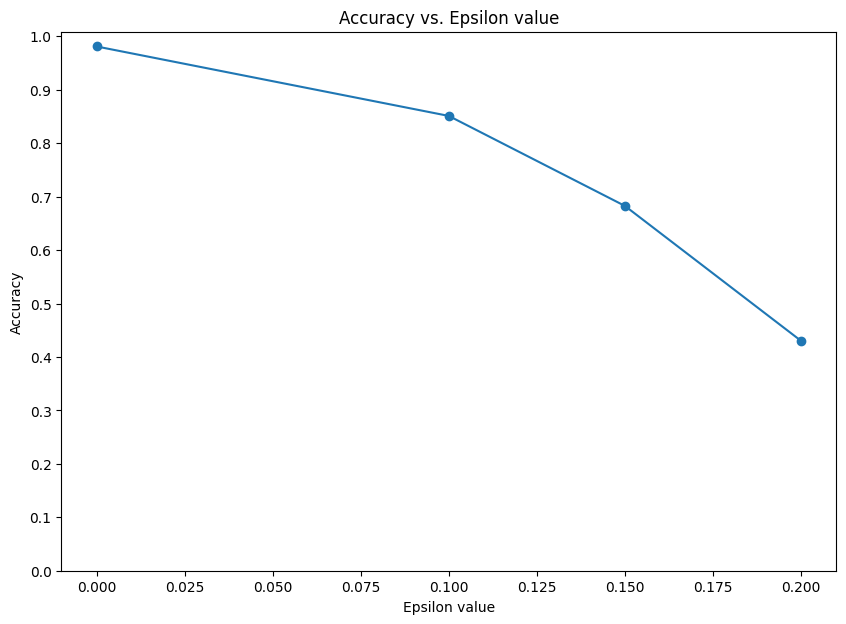

In [11]:
# Initialize figure
plt.figure(figsize = (10, 7))

# Display accuracy vs. Epsilon values plot
plt.plot(epsilons, accuracies, "o-")

# Adjust x-axis and y-axis labels and ticks
plt.yticks(np.arange(0, 1.1, step = 0.1))
#plt.xticks(np.arange(0, .35, step = 0.05))
plt.title("Accuracy vs. Epsilon value")
plt.xlabel("Epsilon value")
plt.ylabel("Accuracy")

# Display
plt.show()

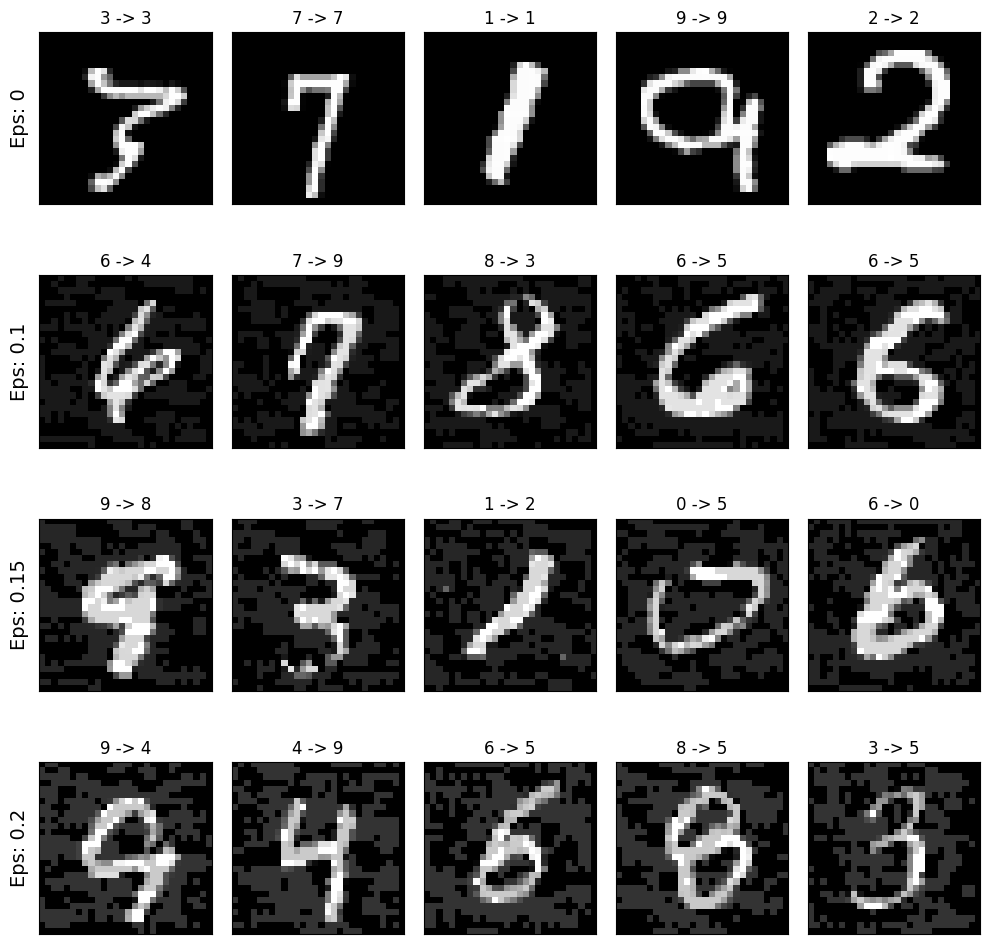

In [12]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0

# Initialize figure
plt.figure(figsize = (10, 10))

# Browse through epsilon values and adversarial examples
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]), cnt)
        
        # Remove x-axis and y-axis ticks from plot
        plt.xticks([], [])
        plt.yticks([], [])
        
        # Labels for y axis
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize = 14)
            
        # Labels for each image subplot
        orig, adv, ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        
        # Display image
        plt.imshow(ex, cmap = "gray")
        
# Display full plot
plt.tight_layout()
plt.show()

### Creating a second model, retraining with defense

We will start by making a second copy of the pre-trained model. This second model will be re-trained using the Madry's defense method, in the hopes of resisting FGSM attacks.

In [13]:
# Load the pretrained model
model2 = Net()
pretrained_model = "./mnist_model.data"
model2.load_state_dict(torch.load(pretrained_model, map_location = 'cpu'))
model2.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [14]:
# MNIST dataset and dataloader
# (This time, get the training data)
ds2 = datasets.MNIST('./data', train = True, download = True, transform = tf)
train_loader = torch.utils.data.DataLoader(ds2, batch_size = 64, shuffle = True)

In [15]:
print(len(train_loader))

938


The retraining will be twofold, we will use normal samples for training, but will also generate our own attack samples using the FGSM attack function and train the model to correctly classify those attack samples, essentially learning to resist such attacks.

In [16]:
# Define a loss function and an optimizer for training
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr = 0.001, momentum = 0.9)

In [17]:
def retrain(model, train_loader, optimizer, criterion, n_iter = 10):
    
    # This will make prints happen every 50 mini-batches
    mod_val = 50
    
    # Train over n_iter epochs
    for epoch in range(n_iter):
        
        # Keep track of the running losses over batches
        running_loss_normal = 0.0
        running_loss_attack = 0.0
        
        for i, data in enumerate(train_loader):
            """
            1. Mini-batches on normal samples
            """
            # Retrieve input images and labels
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            inputs.requires_grad = True

            # Zeroing gradients
            optimizer.zero_grad()

            # Forward, Loss, Backprop
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Keep track of running loss (normal samples)
            running_loss_normal += loss.item()
                
            """
            2. Mini-batches on generated attack samples
            """
            
            # Collect gradients of image
            data_grad = inputs.grad.data
            
            # Call FGSM Attack with the 0.15 epsilon value
            epsilon = .15
            eps_image = fgsm_attack(inputs, epsilon, data_grad)

            # Re-classify the epsilon image
            output2 = model(eps_image)
            # Get the index of the max log-probability
            eps_pred = output2.max(1, keepdim = True)[1]
            
            # Loss, Backprop, Optimize
            loss2 = criterion(output2, labels)
            loss2.backward()
            optimizer.step()

            # Keep track of running loss (attack samples)
            running_loss_attack += loss2.item()
            
            # Display for progress
            if i != 1 and i % mod_val == 1:
                str1 = '[Epoch %d, Batch %5d] Normal Loss: %.3f' %(epoch + 1, i + 1, running_loss_normal/(i+1))
                str2 = 'Attack Loss: %.3f' %(running_loss_attack/(i+1))
                print(str1 + " - " + str2)

The retraining shows very little gains on normal samples, which is expected.

However, the model seems to improve rapidly when it comes to classifying FGSM attack samples, which is a good sign!

In [18]:
retrain(model2, train_loader, optimizer, criterion)

[Epoch 1, Batch    52] Normal Loss: 0.282 - Attack Loss: 0.929
[Epoch 1, Batch   102] Normal Loss: 0.253 - Attack Loss: 0.887
[Epoch 1, Batch   152] Normal Loss: 0.233 - Attack Loss: 0.853
[Epoch 1, Batch   202] Normal Loss: 0.224 - Attack Loss: 0.834
[Epoch 1, Batch   252] Normal Loss: 0.223 - Attack Loss: 0.820
[Epoch 1, Batch   302] Normal Loss: 0.223 - Attack Loss: 0.806
[Epoch 1, Batch   352] Normal Loss: 0.222 - Attack Loss: 0.798
[Epoch 1, Batch   402] Normal Loss: 0.221 - Attack Loss: 0.786
[Epoch 1, Batch   452] Normal Loss: 0.217 - Attack Loss: 0.775
[Epoch 1, Batch   502] Normal Loss: 0.215 - Attack Loss: 0.765
[Epoch 1, Batch   552] Normal Loss: 0.213 - Attack Loss: 0.758
[Epoch 1, Batch   602] Normal Loss: 0.213 - Attack Loss: 0.753
[Epoch 1, Batch   652] Normal Loss: 0.212 - Attack Loss: 0.748
[Epoch 1, Batch   702] Normal Loss: 0.211 - Attack Loss: 0.743
[Epoch 1, Batch   752] Normal Loss: 0.210 - Attack Loss: 0.738
[Epoch 1, Batch   802] Normal Loss: 0.209 - Attack Loss

[Epoch 8, Batch   302] Normal Loss: 0.157 - Attack Loss: 0.467
[Epoch 8, Batch   352] Normal Loss: 0.158 - Attack Loss: 0.468
[Epoch 8, Batch   402] Normal Loss: 0.157 - Attack Loss: 0.468
[Epoch 8, Batch   452] Normal Loss: 0.157 - Attack Loss: 0.468
[Epoch 8, Batch   502] Normal Loss: 0.158 - Attack Loss: 0.468
[Epoch 8, Batch   552] Normal Loss: 0.158 - Attack Loss: 0.467
[Epoch 8, Batch   602] Normal Loss: 0.159 - Attack Loss: 0.467
[Epoch 8, Batch   652] Normal Loss: 0.160 - Attack Loss: 0.469
[Epoch 8, Batch   702] Normal Loss: 0.159 - Attack Loss: 0.468
[Epoch 8, Batch   752] Normal Loss: 0.160 - Attack Loss: 0.469
[Epoch 8, Batch   802] Normal Loss: 0.159 - Attack Loss: 0.468
[Epoch 8, Batch   852] Normal Loss: 0.159 - Attack Loss: 0.466
[Epoch 8, Batch   902] Normal Loss: 0.159 - Attack Loss: 0.466
[Epoch 9, Batch    52] Normal Loss: 0.164 - Attack Loss: 0.455
[Epoch 9, Batch   102] Normal Loss: 0.160 - Attack Loss: 0.460
[Epoch 9, Batch   152] Normal Loss: 0.155 - Attack Loss

In [19]:
# After retraining, set the model in evaluation mode
# (Important, because we have dropout layers!)
model2.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### Testing FGSM attacks on our defended model

In [20]:
epsilons = [0, .1, .15, .2]
accuracies2 = []
examples2 = []

# Run test() function for each epsilon
for eps in epsilons:
    acc, ex = test(model2, device, test_loader, eps)
    accuracies2.append(acc)
    examples2.append(ex)

Epsilon: 0 - Test Accuracy = 9846/10000 = 0.9846
Epsilon: 0.1 - Test Accuracy = 9304/10000 = 0.9304
Epsilon: 0.15 - Test Accuracy = 8786/10000 = 0.8786
Epsilon: 0.2 - Test Accuracy = 7951/10000 = 0.7951


### Visualization part 2 (accuracies vs. epsilon values for both models)

As in previous notebooks, but amended to account for both models.

The retrained and defended model (in red), seems to show robustness compared to the original undefended model (in blue).

A few more iterations of retraining could potentially lead to better results.

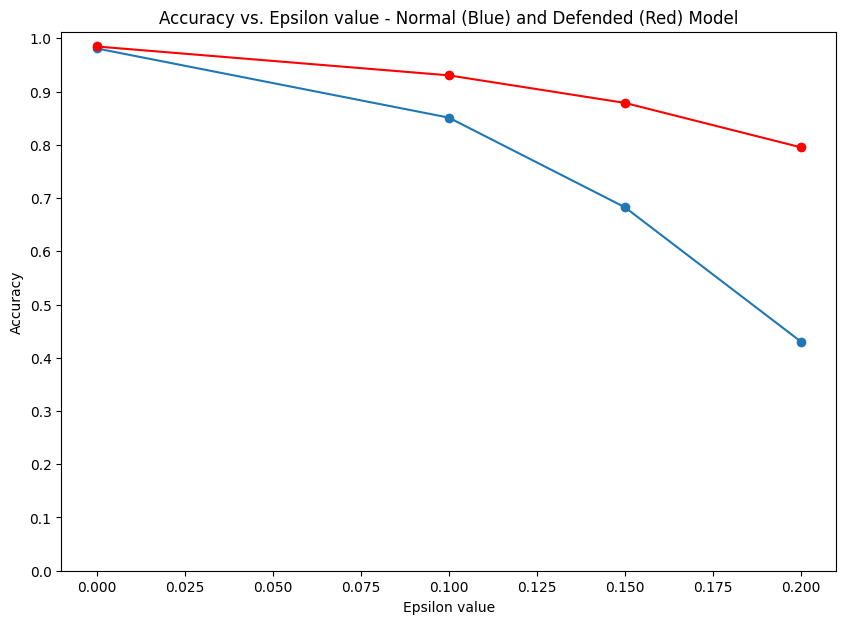

In [21]:
# Initialize figure
plt.figure(figsize = (10, 7))

# Display accuracy vs. Epsilon values plot
plt.plot(epsilons, accuracies, "o-")
plt.plot(epsilons, accuracies2, "o-", color = "red")

# Adjust x-axis and y-axis labels and ticks
plt.yticks(np.arange(0, 1.1, step = 0.1))
#plt.xticks(np.arange(0, .35, step = 0.05))
plt.title("Accuracy vs. Epsilon value - Normal (Blue) and Defended (Red) Model")
plt.xlabel("Epsilon value")
plt.ylabel("Accuracy")

# Display
plt.show()

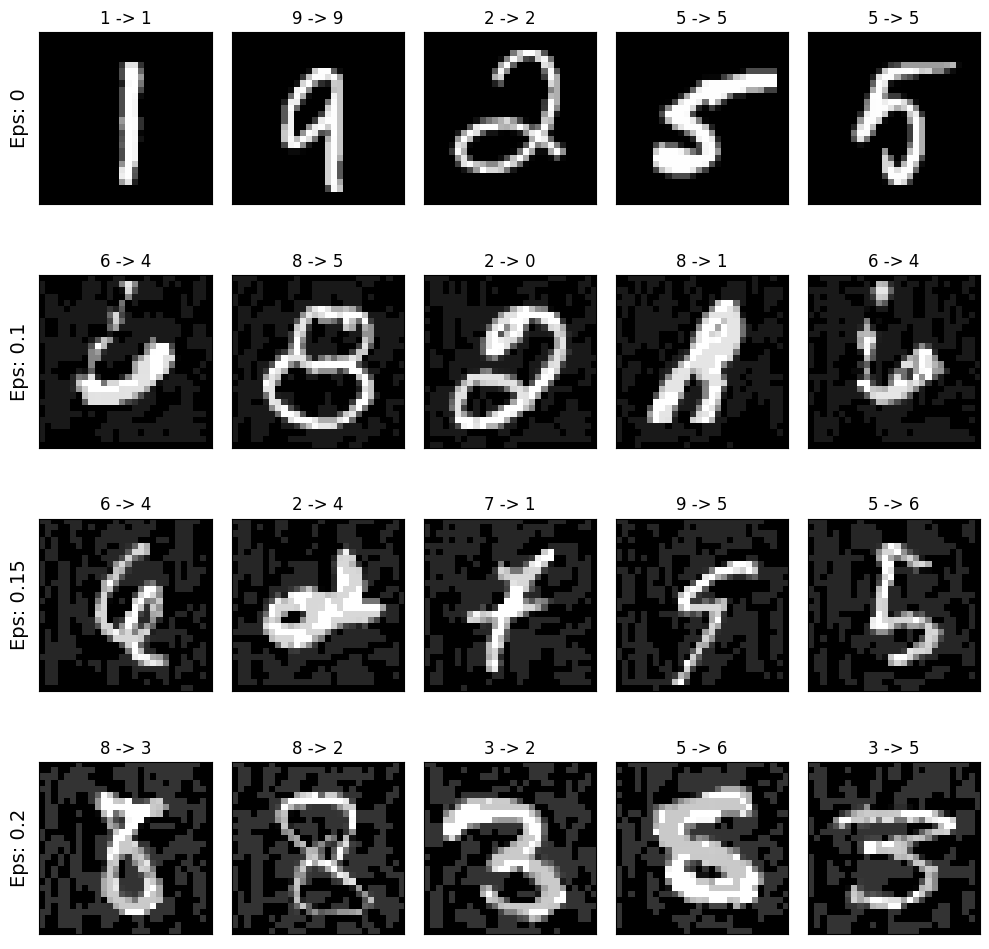

In [22]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0

# Initialize figure
plt.figure(figsize = (10, 10))

# Browse through epsilon values and adversarial examples
for i in range(len(epsilons)):
    for j in range(len(examples2[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples2[0]), cnt)
        
        # Remove x-axis and y-axis ticks from plot
        plt.xticks([], [])
        plt.yticks([], [])
        
        # Labels for y axis
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize = 14)
            
        # Labels for each image subplot
        orig, adv, ex = examples2[i][j]
        plt.title("{} -> {}".format(orig, adv))
        
        # Display image
        plt.imshow(ex, cmap = "gray")
        
# Display full plot
plt.tight_layout()
plt.show()

### What's next?

In the next notebook, we will implement a more advanced defense mechanism, called defensive distillation.